## 嵌入层和线性层的区别

在 PyTorch 中，嵌入层（embedding layers）和线性层（linear layers）在功能上可以实现相似的效果，即通过矩阵乘法将输入转换为输出，但嵌入层在计算效率方面更具优势。

In [1]:
import torch

print("PyTorch version:", torch.__version__)

PyTorch version: 2.5.1+cu121



 
## 1. Using nn.Embedding

In [2]:
# 假设有三个训练例子代表 token IDs in a LLM context
idx = torch.tensor([2, 3, 1])

#  embedding矩阵的行数 = largest token ID + 1.
num_idx = max(idx)+1

# 嵌入维度是超参数
#超参数是指在训练模型之前需要设置的参数，它们不是通过训练数据直接学习得到的，而是通过实验或经验进行调整。
out_dim = 5

In [3]:
#为了确保实验的可重复性，设置一个随机种子
#用小的随机值初始化一个嵌入层

#随机种子的作用是确保在多次运行相同代码时，生成的随机数序列是相同的。
torch.manual_seed(123)

#嵌入层初始化            输入维度：类别总数 如词汇表大小      嵌入维度
embedding = torch.nn.Embedding(num_idx, out_dim)

In [4]:
embedding.weight

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.3035, -0.5880,  1.5810],
        [ 1.3010,  1.2753, -0.2010, -0.1606, -0.4015],
        [ 0.6957, -1.8061, -1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096, -0.4076,  0.7953]], requires_grad=True)

In [5]:
#用嵌入层得到第一个训练例子的向量表示

embedding(torch.tensor([1]))

tensor([[ 1.3010,  1.2753, -0.2010, -0.1606, -0.4015]],
       grad_fn=<EmbeddingBackward0>)

In [9]:
embedding(torch.tensor([2]))

tensor([[ 0.6957, -1.8061, -1.1589,  0.3255, -0.6315]],
       grad_fn=<EmbeddingBackward0>)

In [10]:
idx = torch.tensor([2, 3, 1])
embedding(idx)

tensor([[ 0.6957, -1.8061, -1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096, -0.4076,  0.7953],
        [ 1.3010,  1.2753, -0.2010, -0.1606, -0.4015]],
       grad_fn=<EmbeddingBackward0>)

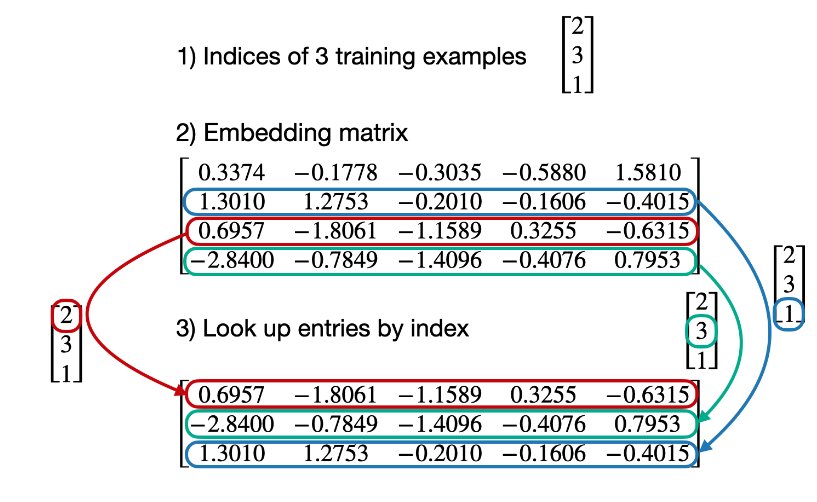

 
## 2. Using nn.Linear

- Now, we will demonstrate that the embedding layer above accomplishes exactly the same as nn.Linear layer on a one-hot encoded representation in PyTorch
- First, let's convert the token IDs into a one-hot representation:

In [11]:
#将token ID转化为one-hot表示
onehot = torch.nn.functional.one_hot(idx)
onehot

tensor([[0, 0, 1, 0],
        [0, 0, 0, 1],
        [0, 1, 0, 0]])

- 初始化 `Linear` layer, 进行 $X W^\top$ 的矩阵乘法

In [12]:
#设置随机种子
torch.manual_seed(123)
#创建线性层              bias=False 指定该线性层不使用偏置项。
linear = torch.nn.Linear(num_idx, out_dim, bias=False)
linear.weight

Parameter containing:
tensor([[-0.2039,  0.0166, -0.2483,  0.1886],
        [-0.4260,  0.3665, -0.3634, -0.3975],
        [-0.3159,  0.2264, -0.1847,  0.1871],
        [-0.4244, -0.3034, -0.1836, -0.0983],
        [-0.3814,  0.3274, -0.1179,  0.1605]], requires_grad=True)

In [ ]:
#和Embedding layer 使用相同的小随机权重
#线性层的权重重新赋值为嵌入层的转置权重。              转置
linear.weight = torch.nn.Parameter(embedding.weight.T)

In [13]:
#使用onehot进行编码
linear(onehot.float())

tensor([[-0.2483, -0.3634, -0.1847, -0.1836, -0.1179],
        [ 0.1886, -0.3975,  0.1871, -0.0983,  0.1605],
        [ 0.0166,  0.3665,  0.2264, -0.3034,  0.3274]], grad_fn=<MmBackward0>)

In [14]:
embedding(idx)

tensor([[ 0.6957, -1.8061, -1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096, -0.4076,  0.7953],
        [ 1.3010,  1.2753, -0.2010, -0.1606, -0.4015]],
       grad_fn=<EmbeddingBackward0>)

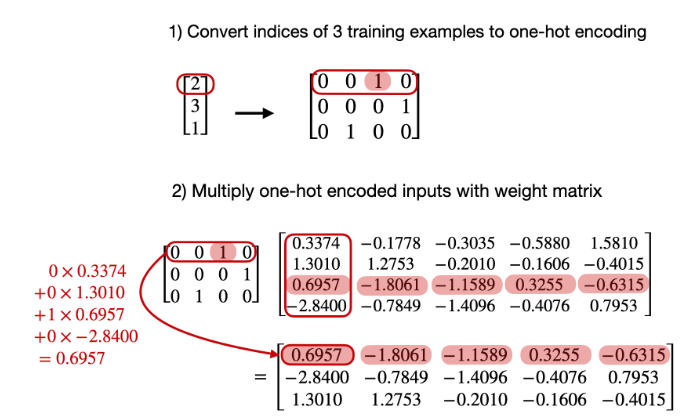

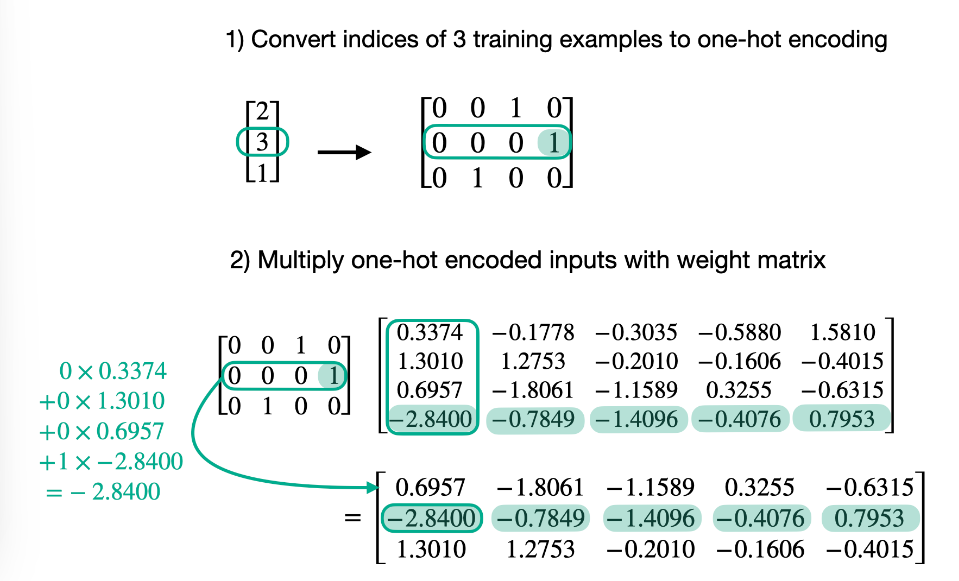

- 将 One-Hot 编码的输入与嵌入层的权重矩阵相乘时，由于大多数元素都是 0，乘法结果几乎等同于查找操作。这意味着只有索引为 1 的元素对最终结果有贡献，其余的乘法（与 0 的乘法）不会影响结果。
- 因此，矩阵乘法的操作实际上只是从嵌入矩阵中查找相应的嵌入向量。

- 尽管矩阵乘法在数学上是等价的，但如果嵌入矩阵非常大，那么这种做法可能会变得低效。因为在执行乘法时，系统需要处理大量与 0 相乘的计算，这些计算是多余的。
- 嵌入层通过直接查找嵌入向量来实现同样的功能，这样就避免了不必要的乘法运算，从而提高了计算效率。